# II - Equilibrium calculations

### Equilibrium explanations

**Equilibrium calculations** are usually performed to obtain the adiabatic flame temperature, the equilibrium composition, and the thermodynamic state of a specific mixture under given conditions. These are virtually performed in every simulation.<br>
For example, Cantera will call its equilibrium solver to initialize the gas state before trying to obtain a solution to the equations for a free flame. As such, it is interesting to understand how Cantera proceeds.

There are 2 different types of solver currently implemented for equilibrium calculation in Cantera that
deserves our attention :
- **The element potential 'ChemEquil' solver**<br>
The class ChemEquil implements a chemical equilibrium solver for single-phase solutions. It is a
"non-stoichiometric" solver in the terminology of Smith and Missen, meaning that every intermediate
state is a valid chemical equilibrium state, but does not necessarily satisfy the element constraints.
<br>
Non-stoichiometric methods are faster when they converge, but stoichiometric ones tend to be more
robust.
- **The 'VCS' chemical equilibrium solver**<br>
The other type of solver is designed to be used to set a mixture containing one or more phases to
a state of chemical equilibrium. It uses a "stoichiometric" algorithm, in which each intermediate
state satisfies the element constraints but is not a state of chemical equilibrium. 
<br>
More specifically, it
implements the VCS algorithm, described in Smith and Missen, "Chemical Reaction Equilibrium". It
finds a set of component species and a complete set of formation reactions for the non-components in
terms of the components.

As expected, the **ChemEquil solver is the fastest** of the Cantera equilibrium solvers for many single-
phase equilibrium problems (particularly if there are only a few elements but very many species), **but
can be less stable**. <br>
Problem situations include low temperatures where only a few species have non-zero
mole fractions, precisely stoichiometric compositions (we will see an example shortly). In general, if
speed is important, this solver should always be tried first before falling back to another one in case of
failure.

### The function equilibrate

The default setting in Cantera, when launching an equilibrium calculation without specifying
the solver, is to try the 'vcs' before falling back to another vcs solver labelled 'gibbs' :
<code>
gas.equilibrate('TP')
</code>

The equilibrate function can be applied on a single phase or on a mixture. Here, we recall its definition:
<code>
equilibrate(self, XY, solver, double rtol, int maxsteps, int maxiter, int loglevel)
</code>
<br>
Parameters:
<code>
XY                - A two-letter string, which must be one of the set: ['TP','TV','HP','SP','SV','UV'].
solver            - Specifies the equilibrium solver to use. May be one of the following :
    element_potential = A fast solver using the element potential method.
    gibbs             = A slower but more robust Gibbs minimization solver.
    vcs               = The VCS non-ideal equilibrium solver.
    auto              = The element potential solver will be tried first, then if it fails the gibbs solver will be
                        tried.
rtol              - The relative error tolerance.
maxsteps          - Maximum number of steps in composition to take to find a converged solution.
maxiter           - This specifies the number of outer iterations on T or P when some property pair other than TP is
                    specified (only for 'gibbs').
loglevel          - Determines the amount of output displayed during the solution process. 0 indicates no output, while larger numbers produce successively more verbose information.
</code>


### Useful python imports

In [1]:
import cantera as ct
import numpy as np
import csv
from matplotlib import *
import matplotlib.pyplot as plt
import sys

## 1. Simple homogeneous equilibrium of a gas

<div class="alert alert-danger "><b> Please create the gas object so that :<br>
- the mechanism used is the gri30<br>
- this is an air/CH4 mix<br>
- the mix is at stoichiometry<br>
- the temperature is 300K and the pressure 1 bar.
<b>

In [3]:
gas = ct.Solution('gri30.yaml')           # create an object representing the gas phase

                    # set the composition of the gas

gas.TP = 300,100000
gas.set_equivalence_ratio(1.0,'CH4:1','O2:1, N2:3.79')      # set initial state

gas.equilibrate('TP')                 # equilibrate using Temperature (T) and Pressure (P)

print(gas())


  gri30:

       temperature   300 K
          pressure   1e+05 Pa
           density   1.1079 kg/m^3
  mean mol. weight   27.636 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -2.9979e+06       -8.2849e+07  J
   internal energy       -3.0882e+06       -8.5344e+07  J
           entropy            7232.2        1.9987e+05  J/K
    Gibbs function       -5.1676e+06       -1.4281e+08  J
 heat capacity c_p            1110.9             30700  J/K
 heat capacity c_v            810.01             22385  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               H2O           0.12323           0.18904           -121.34
               CO2           0.15052          0.094518           -185.85
                N2           0.72625           0.71645            -23.38
     

As you see, the gas has been equilibrated since it now shows only quantities for the product of the reaction (H2O and CO2). You can try to set yourself out of the perfect mixing (for example set CH4 to 0.4 and to 0.6) and see the impact on the species in the mix at the end.

## 2. Failure of a solver

Cantera has 3 different equilibrium solvers, 2 of them are worth mentionning: 
- The 'ChemEquil' solver uses the element potential method for homogeneous equilibrium in gas mixtures. It is fast, but sometimes doesn't converge. 
- The 'VCS' solver uses the VCS algorithm (Gibbs minimization), which is slower but more robust. It can also handle multiple phases.<br>
Here we'll solve a problem for which the ChemEquil solver fails, but the VCS solver has no problem.

### Properties of the gas

In [4]:
pressure = 1.0e5                # pressure
temperature = 400.0             # unburned gas temperature
comp = 'CH4:0.5, O2:1, N2:3.76' # premixed gas composition

gas = ct.Solution('gri30.yaml')
gas.TPX = temperature, pressure, comp

### Initial state of the gas

In [5]:
print("******************************************************** ")
print("    Initial state :")
print("******************************************************** ")
print("P =  ", "%10.4e  " % (gas.P) + "    Pa")
print("T =  ", "%10.4e  " % (gas.T) + "    K")
print("V =  ", "%10.4e  " % (gas.volume_mass) + "    m3/kg")
print("U =  ", "%10.4e  " % (gas.int_energy_mass) + "    J/kg")
print("H =  ", "%10.4e  " % (gas.enthalpy_mass) + "    J/kg")
print("S =  ", "%10.4e  " % (gas.entropy_mass) + "    J/kg/K")
print("")
print("")

******************************************************** 
    Initial state :
******************************************************** 
P =   1.0000e+05      Pa
T =   4.0000e+02      K
V =   1.2035e+00      m3/kg
U =   -2.6590e+05      J/kg
H =   -1.4554e+05      J/kg
S =   7.5652e+03      J/kg/K




### Comparing chemical potentials and element potentials 

Here, the chemical potentials (noted mu_xx) are compared to the corresponding calculated values with the element potentials (noted lambda_xx).
For instance, mu_H2 = lambda_H x 2.
This is a good way to check wether the solver has managed to compute the results correctly. The chemical potentials are the one of the vapor phase.

In [6]:
chemeq = np.zeros(gas.n_species)
chemeq = gas.chemical_potentials

mu_H2 = chemeq[gas.species_index("H2")]
mu_OH = chemeq[gas.species_index("OH")]
mu_H2O = chemeq[gas.species_index("H2O")]
mu_O2 = chemeq[gas.species_index("O2")]
lambda_H = chemeq[gas.species_index("H")]
lambda_O = chemeq[gas.species_index("O")]

print()
print("Comparison between Chem potentials and element potentials:")
print()
s_mu_H2 = "%11.4e" % mu_H2
s_lam_mu_H2 = "%11.4e" % (2.0 * lambda_H)
print("mu_H2   : ", s_mu_H2, ",    ", s_lam_mu_H2)

s_mu_O2 = "%11.4e" % mu_O2
s_lam_mu_O2 = "%11.4e" % (2.0 * lambda_O)
print("mu_O2   : ", s_mu_O2, ",    ", s_lam_mu_O2)

s_mu_OH = "%11.4e" % mu_OH
s_lam_mu_OH = "%11.4e" % (lambda_H + lambda_O)
print("mu_OH   : ", s_mu_OH, ",    ", s_lam_mu_OH)

s_mu_H2O = "%11.4e" % mu_H2O
s_lam_mu_H2O = "%11.4e" % (2.0 * lambda_H + lambda_O)
print("mu_H2O  : ", s_mu_H2O, ",    ", s_lam_mu_H2O)


Comparison between Chem potentials and element potentials:

mu_H2   :  -2.3501e+09 ,     -4.2513e+09
mu_O2   :  -8.8089e+07 ,     -4.2260e+09
mu_OH   :  -2.3320e+09 ,     -4.2386e+09
mu_H2O  :  -2.6153e+09 ,     -6.3643e+09


### Program equilibrate

By default, the method equilibrate can be used without giving the solver. It will try first the element_potential solver than the vcs solver. 
Just below, the default behavior of Cantera is illustrated. Don't use that in your everyday calculation, just call gas.equilibrate('TP'), Cantera will handle the rest.

In [8]:
try:
    # print("0")
    gas.equilibrate('TP', solver='element_potential')  # use the ChemEquil solver
except:
    print("")
    print("ChemEquil solver failed! Trying the vcs solver...")
    gas.equilibrate('TP', solver='vcs', max_steps=1500)


ChemEquil solver failed! Trying the vcs solver...


### Compare the results with the initial values

In [9]:
print("")
print("******************************************************** ")
print("    Final state :")
print("    Tadiabatique = " + str(gas.T) + " K")
print("******************************************************** ")
print("P =  ", "%10.4e  " % (gas.P) + "    Pa")
print("T =  ", "%10.4e  " % (gas.T) + "    K")
print("V =  ", "%10.4e  " % (gas.volume_mass) + "    m3/kg")
print("U =  ", "%10.4e  " % (gas.int_energy_mass) + "    J/kg")
print("H =  ", "%10.4e  " % (gas.enthalpy_mass) + "    J/kg")
print("S =  ", "%10.4e  " % (gas.entropy_mass) + "    J/kg/K")
print("")
print("")


******************************************************** 
    Final state :
    Tadiabatique = 400.0 K
******************************************************** 
P =   1.0000e+05      Pa
T =   4.0000e+02      K
V =   1.2035e+00      m3/kg
U =   -3.0232e+06      J/kg
H =   -2.9029e+06      J/kg
S =   7.5570e+03      J/kg/K




### Comparing chemical and element equilibrium for the equilibrate mixture 

In [10]:
chemeq = gas.chemical_potentials
mu_H2 = chemeq[gas.species_index("H2")]
mu_OH = chemeq[gas.species_index("OH")]
mu_H2O = chemeq[gas.species_index("H2O")]
mu_O2 = chemeq[gas.species_index("O2")]
lambda_H = chemeq[gas.species_index("H")]
lambda_O = chemeq[gas.species_index("O")]

print()
print("Comparison between Chem potentials and element potentials:")
print()
s_mu_H2 = "%11.4e" % mu_H2
s_lam_mu_H2 = "%11.4e" % (2.0 * lambda_H)
print("mu_H2   : ", s_mu_H2, ",    ", s_lam_mu_H2)

s_mu_O2 = "%11.4e" % mu_O2
s_lam_mu_O2 = "%11.4e" % (2.0 * lambda_O)
print("mu_O2   : ", s_mu_O2, ",    ", s_lam_mu_O2)

s_mu_OH = "%11.4e" % mu_OH
s_lam_mu_OH = "%11.4e" % (lambda_H + lambda_O)
print("mu_OH   : ", s_mu_OH, ",    ", s_lam_mu_OH)

s_mu_H2O = "%11.4e" % mu_H2O
s_lam_mu_H2O = "%11.4e" % (2.0 * lambda_H + lambda_O)
print("mu_H2O  : ", s_mu_H2O, ",    ", s_lam_mu_H2O)


Comparison between Chem potentials and element potentials:

mu_H2   :  -1.7866e+08 ,     -1.7866e+08
mu_O2   :  -2.8958e+08 ,     -2.8958e+08
mu_OH   :  -2.3412e+08 ,     -2.3412e+08
mu_H2O  :  -3.2345e+08 ,     -3.2345e+08


### Saving the results

In [11]:
csv_file = '2-Output/all_mole_fractions.csv'
with open(csv_file, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['phi', 'T (K)'] + gas.species_names)
    writer.writerow(['1', gas.T] + list(gas.X))
print(('Output written to {0}'.format(csv_file)))

Output written to 2-Output/all_mole_fractions.csv


## 3. Perform adiabatic flame calculations as a function of equivalence ratio

### Set gas composition and interesting parameters

We will now perform **several constant pressure equilibrium calculations of a methane/air mixture, at
an initial temperature of 300K and under atmospheric pressure**, in order to obtain the adiabatic flame temperature and burnt gas state for several equivalence ratios (from 0.3 to 10.0).<br>
The goal of this exercise is to find a way to loop through several gaseous composition, in order to perform several computations in a single script and to plot the result.

### Time to code a real cantera script !

Then it is time for you to play ! Open another terminal folder and create your own Cantera python script.
The goal is to compare the adiabatic flame temperature between gri 2.11 and gri3.0 (go search for them on https://chemistry.cerfacs.fr), for the following operating conditions :
- a temperature of 400K
- a pressure of 2 bars
- a range of equivalence ratio between 0.3 to 3.5
You should obtain the following results:


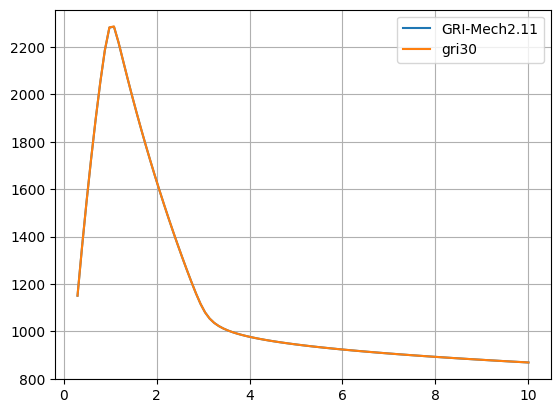

In [12]:
import numpy as np
import matplotlib.pyplot as plt
nb_pts = 100

temp = 400
pres = 200000
phi = np.linspace(0.3,10,nb_pts)

Tad_gas1 = np.zeros(nb_pts)
Tad_gas2 = np.zeros(nb_pts)

gas1 = ct.Solution('Mechanisms/GRI-Mech2.11.yaml')
gas2 = ct.Solution('gri30.yaml')

for i in range(0,len(phi)):
    gas1.TP = temp,pres
    gas2.TP = temp,pres
    gas1.set_equivalence_ratio(phi[i],'CH4:1',{'O2':1,'N2':3.76})
    gas2.set_equivalence_ratio(phi[i],'CH4:1',{'O2':1,'N2':3.76})
    gas1.equilibrate('HP')
    gas2.equilibrate('HP')
    Tad_gas1[i] = gas1.T
    Tad_gas2[i] = gas2.T
plt.figure
plt.plot(phi,Tad_gas1,label='GRI-Mech2.11')
plt.plot(phi,Tad_gas2,label='gri30')
plt.grid()
plt.legend()

# L'image présentée n'est pas pour de méthane mais de l'éthylène (C2H4)

## 4. Compute the low heating value and high heating value of a fuel

In combustion, the low heating value (LHV or PCI in French) corresponds to the energy released when the fuel and $O_2$ are converted into $CO_2$ and $H_2O$. It is directly linked to the formation enthalpy of the species involved and given by :

$$ LHV = \sum_i^c n_i \bar{h_i}(T_ref) $$

Here, we want to compute the LHV for methane. The complete reaction can be written as:

$$ CH_4 + 2 O_2 \to CO_2 + 2 H_2O $$

To compute the LHV, we will use the thermodynamics data from the gri30 mechanism. The mixture will be fixed at the reference state (298K, 1 atm). 

First, we need to compute the enthalpy of the reactants : 

In [13]:
import cantera as ct

In [14]:
gas = ct.Solution('gri30.yaml')

# Set the reactants state
gas.TP = 298, 101325
gas.set_equivalence_ratio(1.0, 'CH4:1.0', 'O2:1.0')

gas()

# Get the enthalpy and the mass fractions of the fuel
h_reactants = gas.enthalpy_mass
Y_CH4 = gas["CH4"].Y[0]


  gri30:

       temperature   298 K
          pressure   1.0132e+05 Pa
           density   1.0911 kg/m^3
  mean mol. weight   26.68 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -9.3222e+05       -2.4871e+07  J
   internal energy       -1.0251e+06       -2.7349e+07  J
           entropy            7652.5        2.0417e+05  J/K
    Gibbs function       -3.2127e+06       -8.5713e+07  J
 heat capacity c_p            1179.9             31480  J/K
 heat capacity c_v            868.29             23166  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.79956           0.66667           -25.079
               CH4           0.20044           0.33333           -53.622
     [  +51 minor]                 0                 0  



Now that we have the enthalpy of the reactants, we need to compute the enthalpy of the products :

In [15]:
# Set the products state
X_products = {'CO2': gas.elemental_mole_fraction('C'), 'H2O': 0.5*gas.elemental_mole_fraction('H')}
gas.TPX = 298, 101325, X_products
#or
#gas.equilibrate('TP') (sometimes you will get minor species that can alter a bit the LHV calculation)

gas()

# Get the products enthalpy
h_products = gas.enthalpy_mass


  gri30:

       temperature   298 K
          pressure   1.0132e+05 Pa
           density   1.0911 kg/m^3
  mean mol. weight   26.68 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy       -1.0959e+07       -2.9239e+08  J
   internal energy       -1.1052e+07       -2.9487e+08  J
           entropy            7587.1        2.0242e+05  J/K
    Gibbs function        -1.322e+07       -3.5271e+08  J
 heat capacity c_p            1303.1             34767  J/K
 heat capacity c_v             991.5             26453  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               H2O           0.45016           0.66667           -120.72
               CO2           0.54984           0.33333           -185.63
     [  +51 minor]                 0                 0  



Now, we can compute the LHV for methane :

In [16]:
LHV = -(h_products - h_reactants) /Y_CH4
print("LHV [MJ/kg] = ", LHV/1e6)

LHV [MJ/kg] =  50.02548811553696


## Conclusion

We have just generated the skeleton of a script to perform a series of common equilibrium calculations
to obtain the constant pressure equilibrium composition of a fuel/air mixture. Starting from there,
you could modify your initial conditions, plot the mole/mass fractions of other species, change the
solver or even try another fuel (methane, acetylene) without changing your mechanism.<br>
Technically, adiabatic flame calculations could also be performed at constant volume: simply invoke
the good equilibrate option of your equilibrate function, 'UV' (see 3.1.2), in your script.
The computation of the low heating value for a fuel has also been investigated in this tutorial